# **Introduction**

This project aims at developing a deep learning model to classify chest X-ray images into four categories: Normal, COVID-19, Pneumonia, and Tuberculosis.

# **Dataset** 

The dataset used for this project is organized into three primary folders: train, test, and val, with each folder containing subdirectories for the following categories: Normal, Pneumonia, COVID-19, and Tuberculosis. A total of 7,135 chest X-ray images are included

# **Data pre-processing**
1.	Data Augmentation:
To address class imbalance, data augmentation was performed on the training dataset for the categories Normal, COVID-19, and Tuberculosis. We applied transformations including random rotation, shifts, shear, zoom, and horizontal flipping. These augmentations expanded the dataset as follows:
•	COVID-19: Generated 8 augmented versions per image, resulting in 3,680 additional images.
•	Normal: Generated 3 augmented versions per image, resulting in 4,023 additional images.
•	Tuberculosis: Generated 5 augmented versions per image, resulting in 3,250 additional images.
These augmentations aimed to enhance dataset diversity and reduce the risk of overfitting while balancing the class distribution.
2.	  Image Resizing:
All images were resized to 224×224 pixels to ensure uniformity and compatibility with the DenseNet121 model's input requirements.

3.	  Image Normalization:
Pixel values were scaled to the range [0,1]. This step was crucial for reducing computational complexity and meeting the input expectations of the pretrained DenseNet121 model


### Import Required Libraries

In [2]:
import os
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import cv2

# **Training the Model**

Check Installed TensorFlow Version:

In [3]:
!pip show tensorflow

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Name: tensorflow
Version: 2.16.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/conda/lib/python3.10/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: explainable-ai-sdk, tensorflow-cloud, tensorflow-serving-api, tensorflow-text, tensorflow_decision_forests, tf_keras, witwidget


In [4]:
# Parameters
img_size = 224  # Input image size for DenseNet121
batch_size = 32
num_classes = 4  
epochs = 20
train_dir = r'/kaggle/input/balanced-dataset/balanced/train'  
val_dir = r'/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/val' 

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)
val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Model Setup
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3)) # remove the classification layer fromm the model
x = base_model.output
x = GlobalAveragePooling2D()(x) # Global Average Pooling layer
x = Dense(256, activation='relu')(x)  # Dense layer
predictions = Dense(num_classes, activation='softmax')(x)  # Output layer

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Compile Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # set output layer


# Callbacks
checkpoint = ModelCheckpoint(
    '/kaggle/working/best_balanced_model.keras',  
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[checkpoint, early_stop]
)

# Fine-tuning 
for layer in base_model.layers[-50:]:  # Unfreeze last 50 layers
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Training
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[checkpoint, early_stop]
)

# Save Final Model
model.save('/kaggle/working/final_balanced_model.keras')

model.save('/kaggle/working/final_balanced_model.h5')  


Found 15500 images belonging to 4 classes.
Found 38 images belonging to 4 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1738106661.733601     111 service.cc:145] XLA service 0x78aed8084f90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738106661.733663     111 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1738106661.733669     111 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/485 ━━━━━━━━━━━━━━━━━━━━ 4:06:47 31s/step - accuracy: 0.2812 - loss: 1.9408

I0000 00:00:1738106675.161870     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


485/485 ━━━━━━━━━━━━━━━━━━━━ 369s 700ms/step - accuracy: 0.8392 - loss: 0.4320 - val_accuracy: 0.8947 - val_loss: 0.2511
Epoch 2/20
485/485 ━━━━━━━━━━━━━━━━━━━━ 264s 536ms/step - accuracy: 0.9309 - loss: 0.1780 - val_accuracy: 0.8684 - val_loss: 0.2516
Epoch 3/20
485/485 ━━━━━━━━━━━━━━━━━━━━ 262s 532ms/step - accuracy: 0.9408 - loss: 0.1590 - val_accuracy: 0.8684 - val_loss: 0.3237
Epoch 4/20
485/485 ━━━━━━━━━━━━━━━━━━━━ 259s 527ms/step - accuracy: 0.9451 - loss: 0.1419 - val_accuracy: 0.8684 - val_loss: 0.2914
Epoch 5/20
485/485 ━━━━━━━━━━━━━━━━━━━━ 261s 531ms/step - accuracy: 0.9486 - loss: 0.1363 - val_accuracy: 0.8684 - val_loss: 0.2334
Epoch 6/20
485/485 ━━━━━━━━━━━━━━━━━━━━ 259s 526ms/step - accuracy: 0.9538 - loss: 0.1214 - val_accuracy: 0.9737 - val_loss: 0.1264
Epoch 7/20
485/485 ━━━━━━━━━━━━━━━━━━━━ 257s 523ms/step - accuracy: 0.9581 - loss: 0.1103 - val_accuracy: 0.8684 - val_loss: 0.2997
Epoch 8/20
485/485 ━━━━━━━━━━━━━━━━━━━━ 257s 523ms/step - accuracy: 0.9626 - loss: 0.10

In [5]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 9,979,086 (38.07 MB)

 Trainable params: 1,339,076 (5.11 MB)

 Non-trainable params: 5,961,856 (22.74 MB)

 Optimizer params: 2,678,154 (10.22 MB)

# **Evaluating the model's performance**

In [6]:
test_dir = '/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/test'

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  
)


# Load the best model
model = load_model('/kaggle/working/best_balanced_model.keras')  

Found 771 images belonging to 4 classes.


In [7]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 689ms/step - accuracy: 0.9335 - loss: 0.1955
Test Accuracy: 0.92
Test Loss: 0.20


In [8]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification Report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", conf_matrix)

25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 554ms/step
               precision    recall  f1-score   support

      COVID19       0.98      0.97      0.98       106
       NORMAL       0.87      0.89      0.88       234
    PNEUMONIA       0.93      0.93      0.93       390
TURBERCULOSIS       1.00      0.98      0.99        41

     accuracy                           0.92       771
    macro avg       0.95      0.94      0.94       771
 weighted avg       0.93      0.92      0.92       771

Confusion Matrix:
 [[103   2   1   0]
 [  0 209  25   0]
 [  1  28 361   0]
 [  1   0   0  40]]


# **Generating Grad-CAM Heatmap**

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Predicted Class Index: 0
Class Probabilities: [9.7226024e-01 2.3972096e-02 3.0535606e-03 7.1411807e-04]


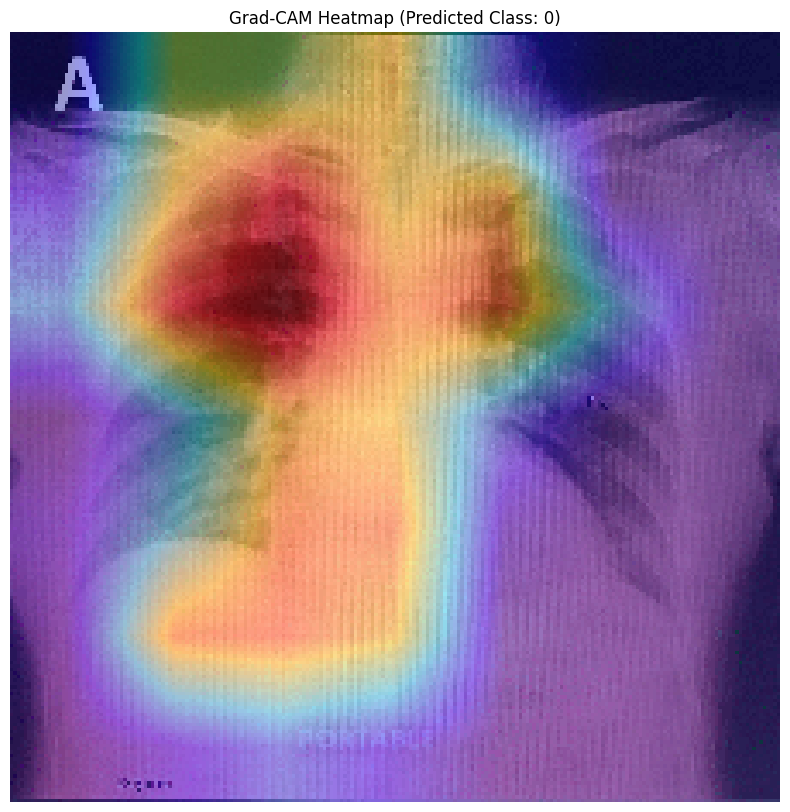

In [9]:
def generate_gradcam_heatmap_simple(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        model.input, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    if grads is None:
        raise ValueError("failed.")

    
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    pooled_grads = tf.reshape(pooled_grads, [1, 1, -1])  

    conv_outputs = conv_outputs[0]  
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Overlay Heatmap on Image
def overlay_heatmap(heatmap, image, alpha=0.4):
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)
    return overlay

# Load and Pre-process Image
def load_and_preprocess_image(image_path, img_size=224):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_size, img_size))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img, img_array

test_img_path = '/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/val/COVID19/COVID19(570).jpg'
last_conv_layer_name = 'conv5_block16_concat'
original_img, test_img_array = load_and_preprocess_image(test_img_path)

# Results
predictions = model.predict(test_img_array)
pred_index = np.argmax(predictions[0])
print(f"Predicted Class Index: {pred_index}")
print(f"Class Probabilities: {predictions[0]}")

# Generate Grad-CAM heatmap
heatmap = generate_gradcam_heatmap_simple(model, test_img_array, last_conv_layer_name, pred_index)
test_img_uint8 = (test_img_array[0] * 255).astype(np.uint8)
heatmap_overlay = overlay_heatmap(heatmap, test_img_uint8)

# print the test image results
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(heatmap_overlay, cv2.COLOR_BGR2RGB))
plt.title(f"Grad-CAM Heatmap")
plt.axis('off')
plt.show()

# **Evaluate random images**

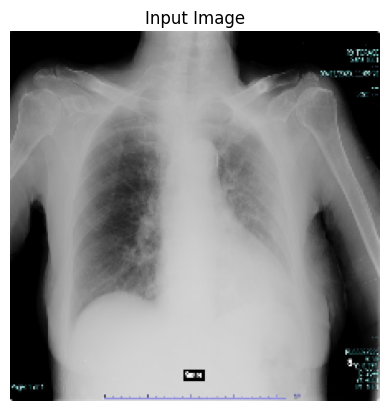

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Class: COVID19


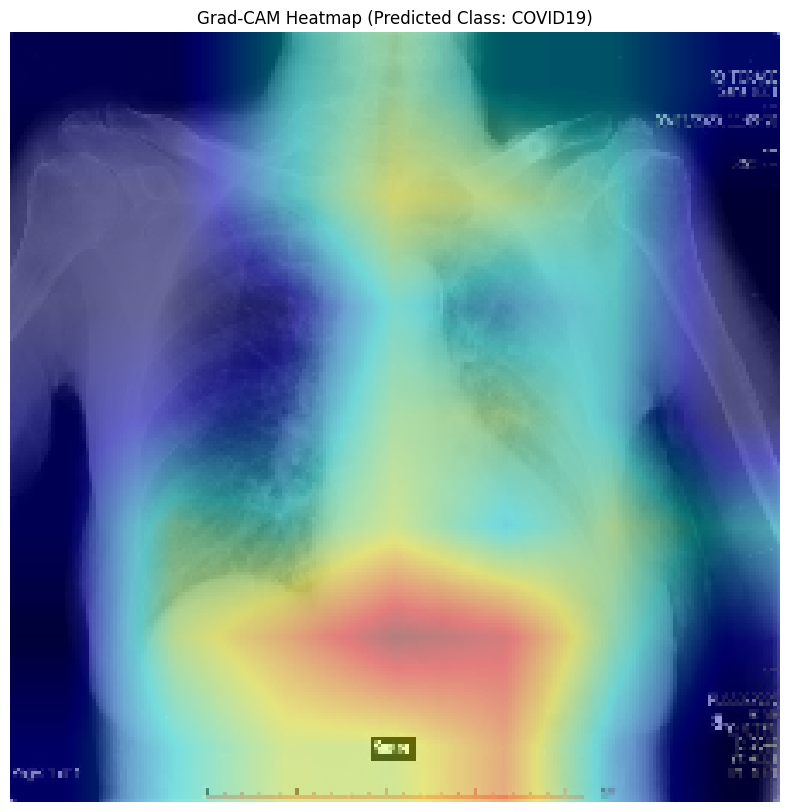

In [10]:
# Load and preprocess the image
image_path = '/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/test/COVID19/COVID19(466).jpg'
img = load_img(image_path, target_size=(224, 224))  

# print the input image
plt.imshow(img)
plt.axis('off')
plt.title("Input Image")
plt.show()

# Preprocess the image
img_array = img_to_array(img) / 255.0 
img_array = np.expand_dims(img_array, axis=0)  

# Predict
single_prediction = model.predict(img_array)
predicted_class = class_labels[np.argmax(single_prediction)]
print(f"Predicted Class: {predicted_class}")

# Overlay the heatmap on the image
heatmap = generate_gradcam_heatmap_simple(model, img_array, last_conv_layer_name='conv5_block16_concat', pred_index=np.argmax(single_prediction))
img_array_uint8 = (img_array[0] * 255).astype(np.uint8)
heatmap_overlay = overlay_heatmap(heatmap, img_array_uint8)

# Display the heatmap results
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(heatmap_overlay, cv2.COLOR_BGR2RGB))
plt.title(f"Grad-CAM Heatmap (Predicted Class: {predicted_class})")
plt.axis('off')
plt.show()

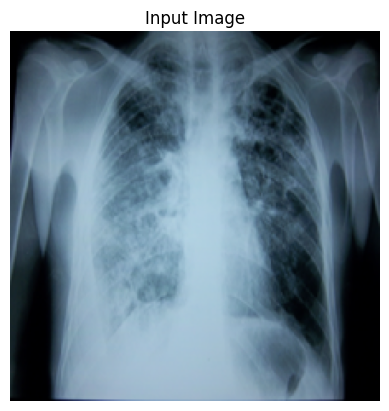

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Class: TURBERCULOSIS


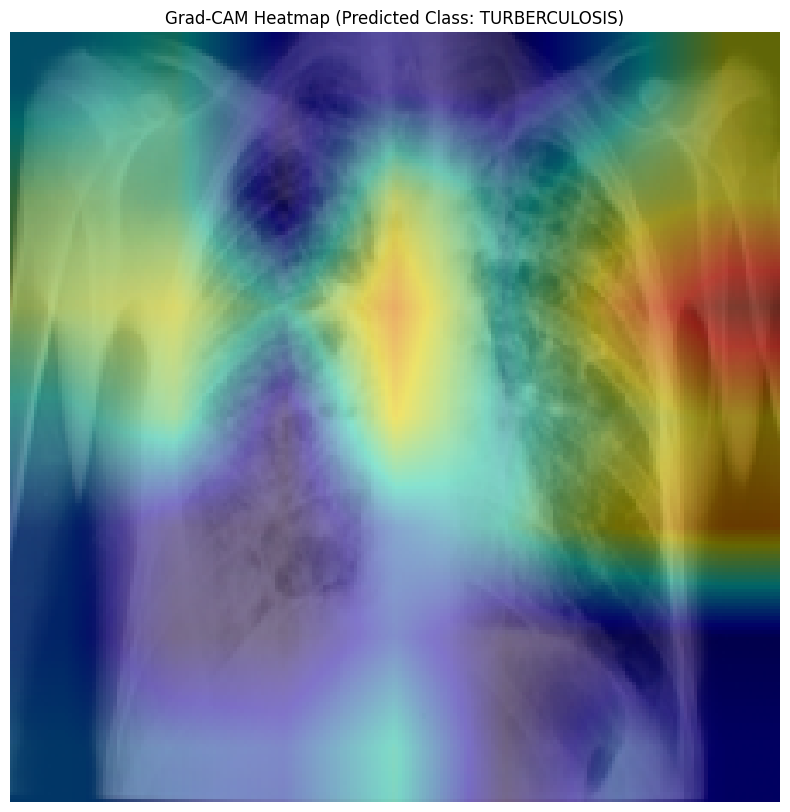

In [11]:
# Load and preprocess the image
image_path = '/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/test/TURBERCULOSIS/Tuberculosis-663.png'
img = load_img(image_path, target_size=(224, 224))  

# print the input image
plt.imshow(img)
plt.axis('off')
plt.title("Input Image")
plt.show()

# Preprocess the image
img_array = img_to_array(img) / 255.0 
img_array = np.expand_dims(img_array, axis=0)  

# Predict
single_prediction = model.predict(img_array)
predicted_class = class_labels[np.argmax(single_prediction)]
print(f"Predicted Class: {predicted_class}")

# Overlay the heatmap on the image
heatmap = generate_gradcam_heatmap_simple(model, img_array, last_conv_layer_name='conv5_block16_concat', pred_index=np.argmax(single_prediction))
img_array_uint8 = (img_array[0] * 255).astype(np.uint8)
heatmap_overlay = overlay_heatmap(heatmap, img_array_uint8)

# Display the heatmap results
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(heatmap_overlay, cv2.COLOR_BGR2RGB))
plt.title(f"Grad-CAM Heatmap (Predicted Class: {predicted_class})")
plt.axis('off')
plt.show()

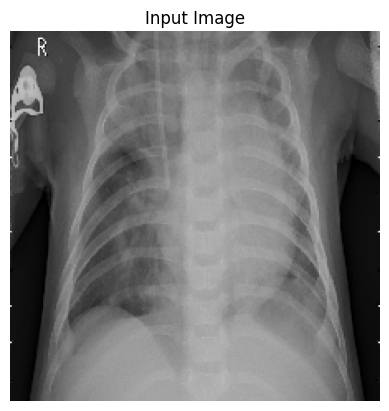

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Predicted Class: PNEUMONIA


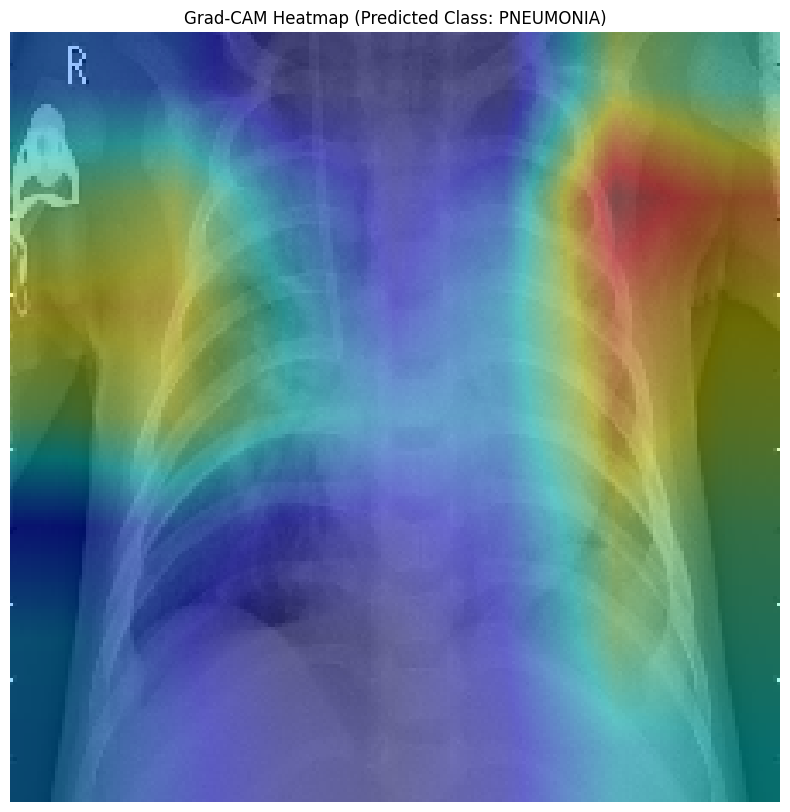

In [12]:
# Load and preprocess the image
image_path = '/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/test/PNEUMONIA/person100_bacteria_481.jpeg'
img = load_img(image_path, target_size=(224, 224))  

# print the input image
plt.imshow(img)
plt.axis('off')
plt.title("Input Image")
plt.show()

# Preprocess the image
img_array = img_to_array(img) / 255.0 
img_array = np.expand_dims(img_array, axis=0)  

# Predict
single_prediction = model.predict(img_array)
predicted_class = class_labels[np.argmax(single_prediction)]
print(f"Predicted Class: {predicted_class}")

# Overlay the heatmap on the image
heatmap = generate_gradcam_heatmap_simple(model, img_array, last_conv_layer_name='conv5_block16_concat', pred_index=np.argmax(single_prediction))
img_array_uint8 = (img_array[0] * 255).astype(np.uint8)
heatmap_overlay = overlay_heatmap(heatmap, img_array_uint8)

# Display the heatmap results
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(heatmap_overlay, cv2.COLOR_BGR2RGB))
plt.title(f"Grad-CAM Heatmap (Predicted Class: {predicted_class})")
plt.axis('off')
plt.show()

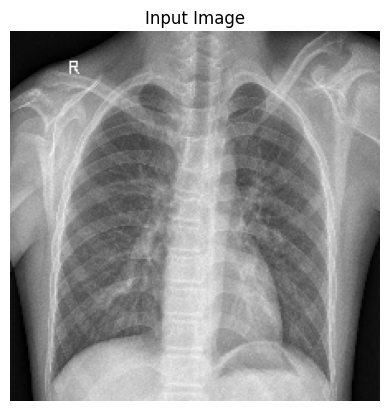

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Class: NORMAL


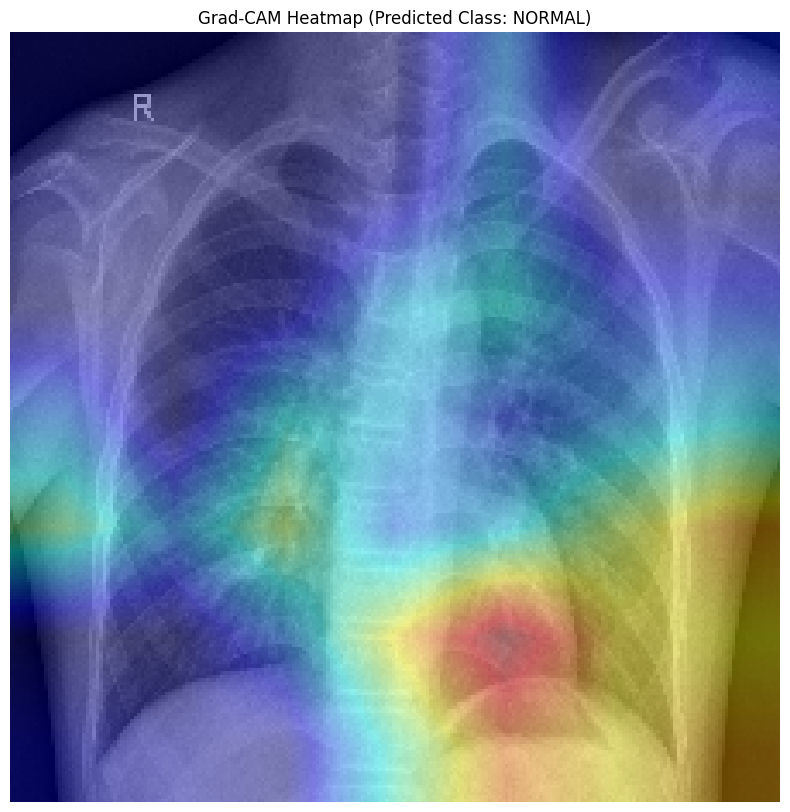

In [13]:
# Load and preprocess the image
image_path = '/kaggle/input/chest-xray-pneumoniacovid19tuberculosis/test/NORMAL/IM-0011-0001-0001.jpeg'
img = load_img(image_path, target_size=(224, 224))  

# print the input image
plt.imshow(img)
plt.axis('off')
plt.title("Input Image")
plt.show()

# Preprocess the image
img_array = img_to_array(img) / 255.0 
img_array = np.expand_dims(img_array, axis=0)  

# Predict
single_prediction = model.predict(img_array)
predicted_class = class_labels[np.argmax(single_prediction)]
print(f"Predicted Class: {predicted_class}")

# Overlay the heatmap on the image
heatmap = generate_gradcam_heatmap_simple(model, img_array, last_conv_layer_name='conv5_block16_concat', pred_index=np.argmax(single_prediction))
img_array_uint8 = (img_array[0] * 255).astype(np.uint8)
heatmap_overlay = overlay_heatmap(heatmap, img_array_uint8)

# Display the heatmap results
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(heatmap_overlay, cv2.COLOR_BGR2RGB))
plt.title(f"Grad-CAM Heatmap (Predicted Class: {predicted_class})")
plt.axis('off')
plt.show()